## The Generalized Roy Model


### Preliminaries

In [123]:
from grmpy.simulate.simulate_auxiliary import simulate_unobservables
from grmpy.test.random_init import print_dict
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from grmpy.read.read import read
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm
from pylab import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import grmpy
import yaml


rcParams["figure.figsize"] = 15, 10
rcParams["font.size"] = 18

%matplotlib inline
from IPython.core.display import display, HTML

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### General Framwork

\begin{align*}
&\textbf{Potential Outcomes} & & \textbf{Choice}  &\\
& Y_{1,i} = \mu_1(X_i) + U_{1,i} &  &C_i = \mu_C(Z_i) - V &\\
& Y_{0,i} = \mu_0(X_i) + U_{0,i} &  & D_i = \left\{
\begin{array}{ll}
1 & if \ C_i > 0 \\
0 &  \text{otherwise}\\
\end{array}
\right.  &\\
&&&&\\
&\textbf{Distributional Characteristics}&&&\\
&\{U_{1}, U_{0}, V\} \sim \left(0, \Sigma\right)&&&\\
&&&&\\
& \textbf{Observed Outcome} &&&\\
& Y_i = D_i Y_{1,i} + (1-D_i) Y_{0,i} &&&
\end{align*}

#### Choice Process

- $Z_i$ captures all observable factors that affect the decision of an individual to select itself into treatment


- $V_i$ denotes (from perspective of the econometrician) unobservable components that drive the selection decision (Note: V enters with a negative sign $\Rightarrow$ conditional on $Z_i$, high values of $V_i$ indicate a lower propensity to select into treatment


- $C_i$ is the latent propensity indicator of individual $i$ 


- $D_i$ indicates whether an individual selects itself in the treatment group


- Furthermore we can rearrange $D_i$ s.t. the individual selects into treatment if

\begin{align*}
&\;\mu_C(Z_i) > V_i\\
\Leftrightarrow&\;F_V(\mu_C(Z_i)) > F_V(V_i)\\
&\\
\Rightarrow& \; D_i = \mathbb{1}\{F_V(\mu_C(Z_i)) > F_V(V_i)\}
\end{align*}

- $F_V(\mu_C(Z_i))$: Probability of being treated given an individual's observable characteristics (propensity score)


- $F_V(V_i)$: The quantile of $V$'s distribution the individual's realization $V_i$ is located in

$\Rightarrow$ **The individuals select themselves into treatment when their propensity score outruns the quantile of the distribution $V_i$**

#### Outcomes

- $(Y_{1,i}, Y_{0,i})$ denotes the set of potential outcomes of individual $i$


- $Y_i$ denotes the observable outcome of individual $i$


- Rearranging the outcome equation leads to:


\begin{align*}
Y_i = Y_{0,i} + D_i \underbrace{(Y_{1,i} - Y_{0,i})}_{\Delta_i}
\end{align*}

- $\Delta_i$ : Causal effect of treatment for individual $i$

**Evaluation Problem**

The set of equations above entails one of the most crucial challenges for the evaluation of policy interventions. We as researchers are not able to observe the potential outcome space for an individual but instead we observe either $Y_{1,i}$ or $Y_{0,i}$ for one and the same individual dependent on the individual's selection decision. This is referred to as the **evaluation problem**.

### Heterogeneity

Central question in all econometrics of policy analysis:

_What gives rise to variation and outcomes among, from the econometrician’s perspective, otherwise identical agents?_ (Heckman 2001)

**Answer: Heterogeneity**

\begin{align*}
\Delta_i = Y_{1,i} - Y_{0,i} = \underbrace{\mu_1(X_i) - \mu_0(X_i)}_{\text{average effect}} + \underbrace{U_{1,i} -U_{0,i}}_{\text{individual specific effect}}
\end{align*}

- **Observable heterogeneity:** 

    * Is reflected by the first term of the equation.
    
    * Denotes the differences between individuals, which are based on differences in observable characteristics captured by $X_i$
    
    * Note that since we observe $X_i$, we are able to  
    
    
- **Unobservable heterogeneity:**
    * Represented by the difference in the unobservables.
    * Note: The term *unobservable* does not imply that $U_{1,i}$ and $U_{0,i}$ are completely excluded in an individual's information set. 

**Question: When does unobservable heterogeneity pose problems in the analysis of average effect parameters?**


**Answer: If the individual's selection process depends on unobservable "gains" we have a selection problem.**


This kind of heterogeneity is referred to as **essential heterogeneity** 
* The reaction on interventions are heterogeneous among individuals

* Individuals select their treatment state with at least partly knowledge of their own responses to treatment.


### Parameters of Interest

- In a perfect world we as economists would focus on determining $\Delta_i$. In reality this is impossible due to the aformentioned evaluation problem!


- For this reason, the analysis of conventional treatment effect analysisis is confined to the identification of average effects for specific subgroups. 

- The common subgroups are the whole population ($\Delta^{ATE}$), the treated ($\Delta^{ATE}$) or the untreted share ($\Delta^{ATE}$). The effects are characterized by the following equations

\begin{align*}
\Delta^{ATE} &= E[Y_1 -Y_0] \\
\Delta^{TT}\;\; &= E[Y_1 -Y_0|D=1]\\
\Delta^{TUT} &= E[Y_1 -Y_0|D=0]
\end{align*}

- When treatment is randomly assigned or the selection is not based on the potential outcomes there is no significant difference between the average individuals with different treatment states.


- Therefore all effects are identical! And we can substitute $E[Y_1]$ and $E[Y_0]$ with the observed average outcomes $E[Y_1|D=1]$ and $E[Y_0|D=0]$.


\begin{align*}
\Delta^{ATE} =  \Delta^{TUT} =  \Delta^{TT} = E[Y_1|D=1] - E[Y_0|D=0]
\end{align*}

In [124]:
%%file files/no_eh.grmpy.yml
---
SIMULATION:
    agents: 10000
    seed: 2356
    source: data
ESTIMATION:
    file: data.grmpy.txt
    output_file: output/est.grmpy.info
    dependent: Y
    indicator: D
TREATED:
    params:
    - 1.0
    - 0.555
    order:
    - const
    - X2
UNTREATED:
    params:
    - 0.5
    - 0.25
    order:
    - const
    - X2
CHOICE:
    params:
    - 0.378
    - -0.39
    order:
    - const
    - X3
DIST:
    params:
    - 0.2
    - 0.0
    - 0.
    - 0.2
    - 0.0
    - 1.0
VARTYPES:
    const: nonbinary
    X2: nonbinary
    X3: nonbinary

Overwriting files/no_eh.grmpy.yml


In [125]:
df = grmpy.simulate("files/no_eh.grmpy.yml")

In [126]:
indicator = df.D == 1
Delta = df["Y1"] - df["Y0"]
ATE = np.mean(df["Y1"] - df["Y0"])
TT = np.mean(df[indicator]["Y1"] - df[indicator]["Y0"])
TUT = np.mean(df[~indicator]["Y1"] - df[~indicator]["Y0"])


effect_est = np.mean(df[indicator]["Y"]) - np.mean(df[~indicator]["Y"])

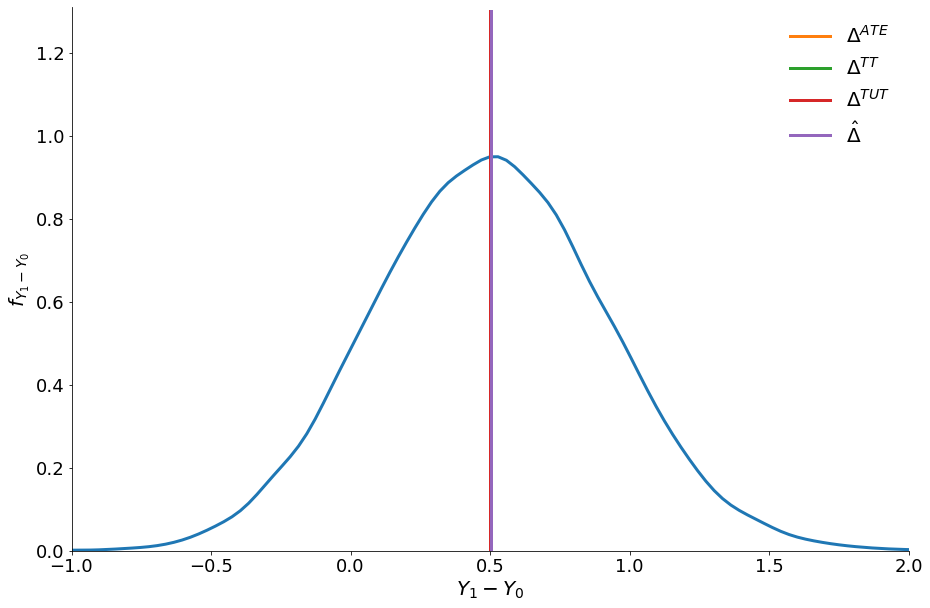

In [127]:
# set up figure object
ax = plt.figure(figsize=(15, 10))
plt.ylabel("$f_{Y_1 - Y_0}$", fontsize=20)
plt.xlabel("$Y_1 - Y_0$", fontsize=20)
plt.axis([-1, 2, 0.0, 1.31])

# plot distribution of individual effects
sns.distplot(Delta, kde=True, hist=False)

# plot average effect parameters
plt.plot([ATE, ATE], [0.00, 1.3], label="$\Delta^{ATE}$")
plt.plot([TT, TT], [0.00, 1.3], label="$\Delta^{TT}$")
plt.plot([TUT, TUT], [0.00, 1.3], label="$\Delta^{TUT}$")
plt.plot([effect_est, effect_est], [0.00, 1.3], label="$\hat{\Delta}$")


plt.legend(prop={"size": 20})

- The figure should not lead to the false assumptions that all introduced parameters measure the same effect.

- If individuals select themselves into treatment based on outcome related characteristics (the potential outcomes $Y-1, Y_0$ are no longer independent of the treatment status $D$), we can observe differences between the parameters.

- These differences are linked to the selection process. Unlike in the abscence of essential heterogeneity, individuals who select themselves into treatment differ inherently from individuals who do not in respect of their unobservable characteristics.

\begin{align*}
E[Y_1|D=1] - E[Y_0|D=0] = \underbrace{E[Y_1-Y_0]}_{\Delta^{ATE}} \\
+\underbrace{E[Y_1 -Y_0|D=1] - E[Y_1-Y_0]}_{\text{selection on gains}} \\
+\underbrace{E[Y_0|D=1] - E[Y_0|D=0]}_{\text{selection on endowments}}
\end{align*}

The bias can be decomposed in two different components:


**Selection on endowment bias**  
As indicated by the equation above, differences in endowments ($Y_0$) between treated and untreated individuals lead to a bias. This reflects that there exist difference in outcomes between the treated and untreated share of the population even without the treatment. 


**Selection on gains bias**  
The selection on gains bias illustrates that the average benefit for individuals who select themselves into treatment differs from the effect of treatment that do not. 



**NOTE:** The type of bias depends on the parameter of interest for which the effect should be measured.




In [128]:
%%file files/eh.grmpy.yml
---
SIMULATION:
    agents: 10000
    seed: 2356
    source: data
ESTIMATION:
    file: data.grmpy.txt
    output_file: output/est.grmpy.info
    dependent: Y
    indicator: D
TREATED:
    params:
    - 1.0
    - 0.555
    order:
    - const
    - X2
UNTREATED:
    params:
    - 0.5
    - 0.25
    order:
    - const
    - X2
CHOICE:
    params:
    - 0.378
    - -0.39
    order:
    - const
    - X3
DIST:
    params:
    - 0.2
    - 0.0
    - -0.15
    - 0.2
    - 0.02
    - 1.0
VARTYPES:
    const: nonbinary
    X2: nonbinary
    X3: nonbinary

Overwriting files/eh.grmpy.yml


In [129]:
df_eh = grmpy.simulate("files/eh.grmpy.yml")

In [130]:
indicator = df_eh.D == 1
Delta = df_eh["Y1"] - df_eh["Y0"]
ATE = np.mean(df_eh["Y1"] - df_eh["Y0"])
TT = np.mean(df_eh[indicator]["Y1"] - df_eh[indicator]["Y0"])
TUT = np.mean(df_eh[~indicator]["Y1"] - df_eh[~indicator]["Y0"])

effect_estimate = np.mean(df_eh[indicator]["Y"]) - np.mean(df_eh[~indicator]["Y"])

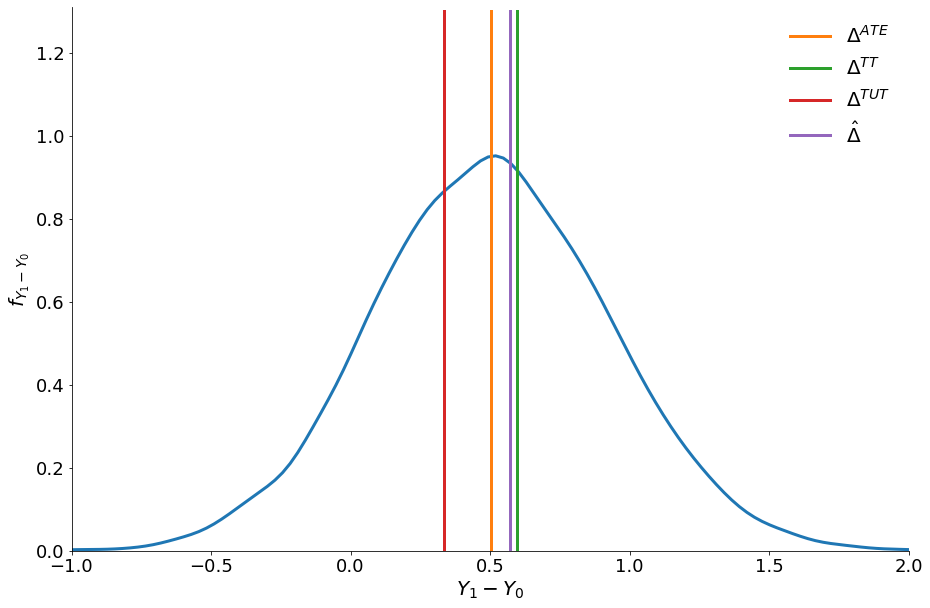

In [131]:
# set up figure object
ax = plt.figure(figsize=(15, 10))
plt.ylabel("$f_{Y_1 - Y_0}$", fontsize=20)
plt.xlabel("$Y_1 - Y_0$", fontsize=20)
plt.axis([-1, 2, 0.0, 1.31])

# plot distribution of individual effects
sns.distplot(Delta, kde=True, hist=False)

# plot average effect parameters
plt.plot([ATE, ATE], [0.00, 1.3], label="$\Delta^{ATE}$")
plt.plot([TT, TT], [0.00, 1.3], label="$\Delta^{TT}$")
plt.plot([TUT, TUT], [0.00, 1.3], label="$\Delta^{TUT}$")
plt.plot([effect_estimate, effect_estimate], [0.00, 1.3], label="$\hat{\Delta}$")


plt.legend(prop={"size": 20})

Text(0.5, 0.98, 'Abscence of essential heterogeneity')

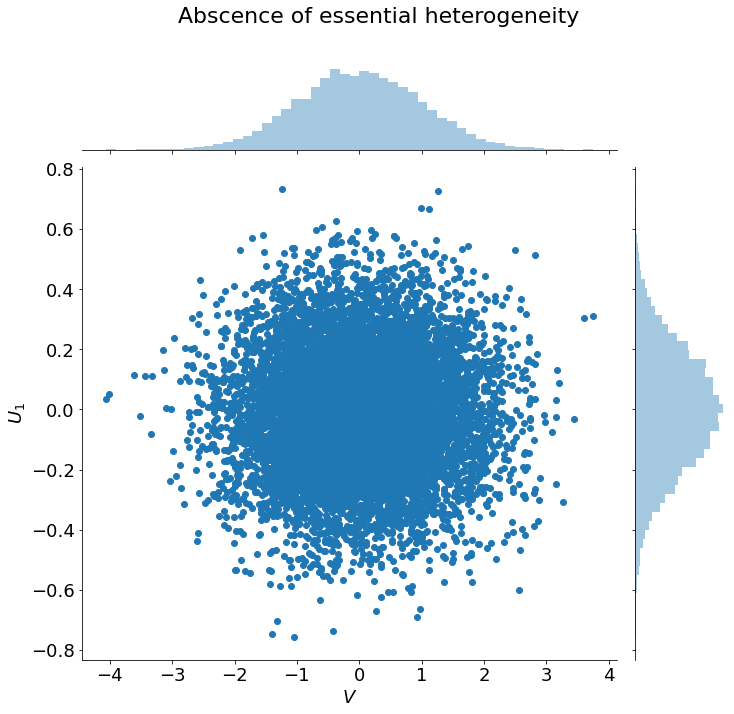

In [132]:
g1 = sns.jointplot(df["V"], df["U1"], stat_func=None, height=10).set_axis_labels(
    "$V$", "$U_1$", fontsize=18
)
g1.fig.subplots_adjust(top=0.9)
g1.fig.suptitle("Abscence of essential heterogeneity", fontsize=22)

Text(0.5, 0.98, 'Presence of essential heterogeneity')

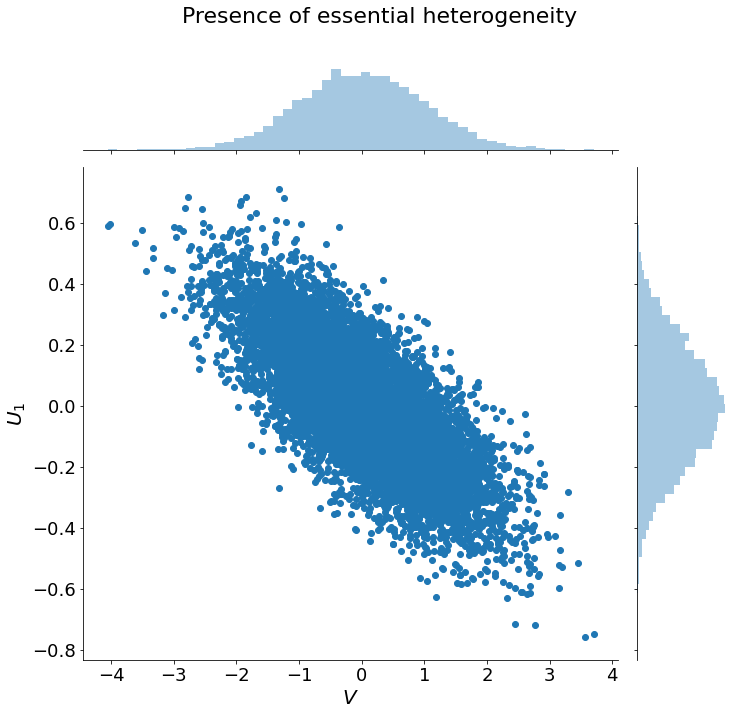

In [133]:
g2 = sns.jointplot(df_eh["V"], df_eh["U1"], stat_func=None, height=10).set_axis_labels(
    "$V$", "$U_1$", fontsize=20
)
g2.fig.subplots_adjust(top=0.9)
g2.fig.suptitle("Presence of essential heterogeneity", fontsize=22)

### The Marginal Treatment Effec

- The concept was first introduced by Björklund & Moffitt (1987) and advanced by a broad variety of papers by Heckman & Vytlacil (1999, 2001, 2005, 2007)

- It is defined as the effect of treatment for individuals who are indifferent between taking the treatment and not. In terms of the Roy model framework it is characterized by the following equation

\begin{align*}
\Delta^{MTE}(x,u_D) = E[Y_1 -Y_0|X=x, U_D=u_D]\\
\\
\end{align*}

- It can be interpreted as the *willingness to pay* for treatment participation of individuals with characteristics $Z_i=z$ at the margin


- **Note:** Instead of explicitly assigning one value to a given policy intervention, $\Delta^{MTE}$ provides a continuum of effects along the distribution of the unobservable variable $V$


- $V_i$ enters the choice function $D_i$ with a negative sign $\Rightarrow$ Individuals with $U_D$ close to zero are most likely to select themselves into treatment.
   

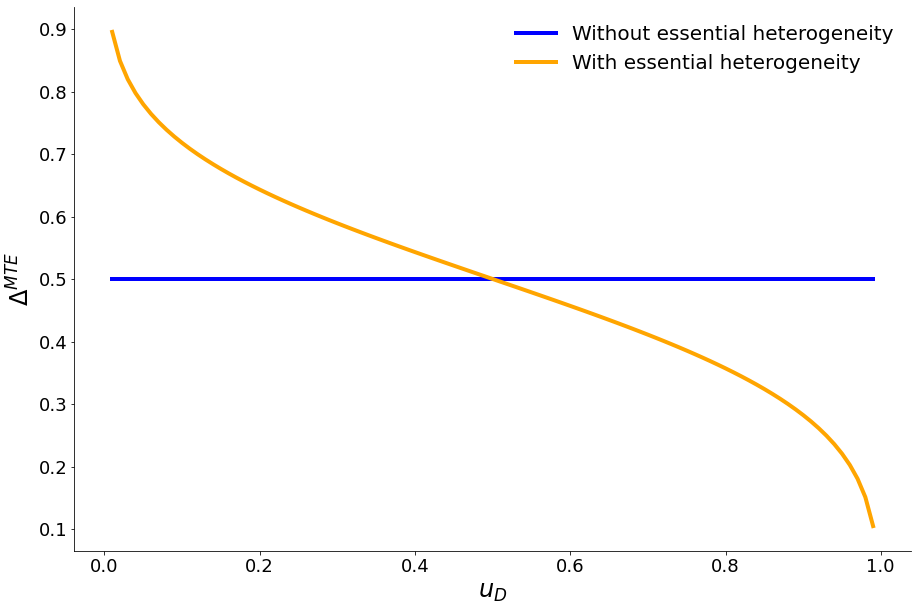

In [134]:
# import init specifications
spec = read("files/no_eh.grmpy.yml")
spec_eh = read("files/eh.grmpy.yml")

# set up a figure object
ax = plt.figure(figsize=(15, 10))

plt.ylabel(r"$\Delta^{MTE}$", fontsize=24)
plt.xlabel("$u_D$", fontsize=24)

labels = ["Without essential heterogeneity", "With essential heterogeneity"]
colors = ["blue", "orange"]
datasets = [df, df_eh]

for counter, init_dict in enumerate([spec, spec_eh]):

    # assign parameters
    beta1 = init_dict["TREATED"]["params"]
    beta0 = init_dict["UNTREATED"]["params"]
    cov1V = init_dict["DIST"]["params"][2]
    cov0V = init_dict["DIST"]["params"][4]

    # define relevant dataset
    data = datasets[counter]

    covariates = init_dict["TREATED"]["order"]
    X = np.mean(data[covariates])

    quantiles = np.arange(0.01, 1.0, 0.01)

    mte = np.dot(X, beta1 - beta0) + (cov1V - cov0V) * norm.ppf(quantiles)
    plt.plot(quantiles, mte, label=labels[counter], color=colors[counter], linewidth=4)


plt.legend(prop={"size": 20})

- $\Delta^{MTE}$ is constant in the absence of essential heterogeneity whereas decreasing respectively increasing values indicate the presence of essential heterogeneity. Why?

- Additionally whether $\Delta^{MTE}$ is increasing or decreasing along $u_D$ provides information about which kind of selection on gains take place

- In addition it is also possible to derive all conventional effects from $\Delta^{MTE}$ by applying effect specific weights along the distribution of $V$:


\begin{align*}
\omega^{ATE}(x,u_D) &= 1.0\\
\omega^{TT}(x,u_D) &= \frac{\int_{u_D}^{1}f(p|X=x)dp}{E[P|X=x]}\\
\omega^{TUT}(x,u_D) &= \frac{\int_{0}^{u_D}f(p|X=x)dp}{E[1-P|X=x]}\\
\end{align*}

Formally:

\begin{align*}
\Delta^j = \int_0^1 \omega_j(x,u_D) \Delta^{MTE}(x,u_D)du_D\\
\text{ for } j = \text{ ATE, TT, TUT}
\end{align*}

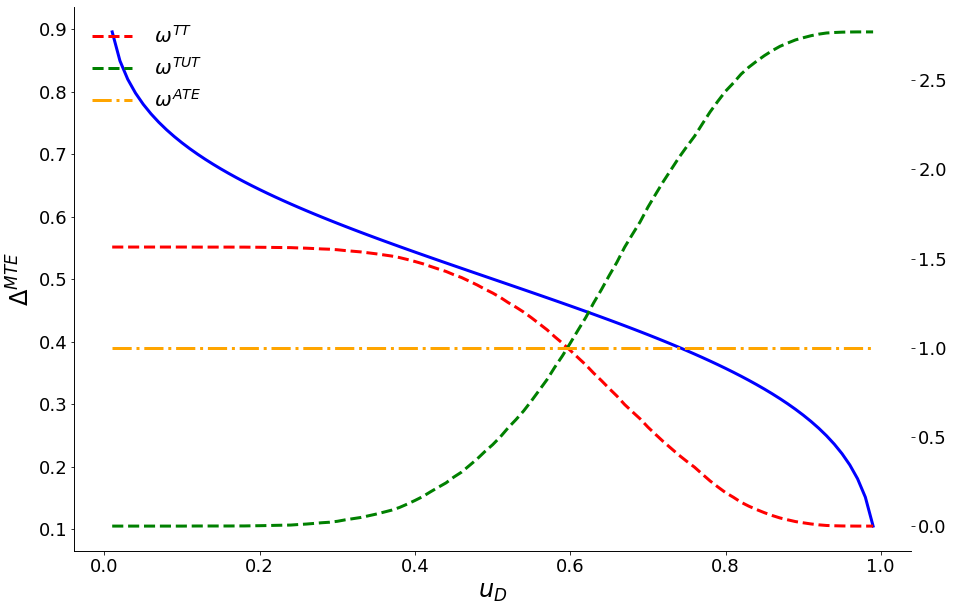

In [135]:
# assign parameter and choice covariates
gamma = spec_eh["CHOICE"]["params"]
Z = df_eh[spec_eh["CHOICE"]["order"]]

# compute average propensity score as well as individual propensity score
propensity_mean = np.mean(norm.cdf(np.dot(gamma, Z.T)))
auxiliary = norm.cdf(np.dot(gamma, Z.T))

# compute the integral
integral_TT = np.array(
    [sum(auxiliary > quantiles[i]) / Z.shape[0] for i in range(len(quantiles))]
)
integral_TUT = np.array(
    [1 - (sum(auxiliary > quantiles[i]) / Z.shape[0]) for i in range(len(quantiles))]
)

# compute the weights
omega_TT = integral_TT / propensity_mean
omega_TUT = integral_TUT / (1 - propensity_mean)
omega_ATE = [1.0] * len(quantiles)


# plot
ax1 = plt.figure(figsize=(15, 10)).add_subplot(111)

plt.ylabel(r"$\Delta^{MTE}$", fontsize=24)
plt.xlabel("$u_D$", fontsize=24)
ax1.plot(quantiles, mte, color="blue", label=" $\Delta^{MTE}$", linewidth=3.0)
ax2 = ax1.twinx()


ax2.plot(
    quantiles,
    omega_TT,
    color="red",
    linestyle="--",
    label=" $\omega^{TT}$",
    linewidth=3.0,
)

ax2.plot(
    quantiles,
    omega_TUT,
    color="green",
    linestyle="--",
    label=" $\omega^{TUT}$",
    linewidth=3.0,
)

ax2.plot(
    quantiles,
    omega_ATE,
    color="orange",
    linestyle="-.",
    label=" $\omega^{ATE}$",
    linewidth=3.0,
)

plt.legend(prop={"size": 20})

In [136]:
string = "      True Values  Weighted Values\n\nATE:{0:>10.5f}{3:>15.5f}\nTT:{1:>11.5f}{4:>15.5f}\nTUT:{2:>10.5f}{5:>15.5f}"

# Apply weights to the mte
ATE_w = np.mean(np.multiply(np.array(mte), omega_ATE))
TT_w = np.mean(np.multiply(np.array(mte), omega_TT))
TUT_w = np.mean(np.multiply(np.array(mte), omega_TUT))
effects = [ATE, TT, TUT, ATE_w, TT_w, TUT_w]

# print comparison to the true values
print(string.format(*effects))

print("\n\n\nNaive comparison: {:.5f}".format(effect_estimate))

      True Values  Weighted Values

ATE:   0.50343        0.50062
TT:    0.59764        0.59144
TUT:   0.33638        0.33977



Naive comparison: 0.57154


#### Link to Local Average Treatment Effect

- The concept of the marginal treatment effect is closely related to the local average treatment effect ($\Delta^{LATE}$)


- More specifically, it can be shown that $\Delta^{LATE}$ converges to $\Delta^{MTE}$. It can be represented as follows:

\begin{align*}
\Delta^{LATE}(u_D, u^{'}_D x) = E[Y_1 -Y_0| u_D > U_D > u^{'}_D, X=x]
\end{align*}


- where $u_D$  and $u'_D$ are defined as the propensity scores for $Z=z$ and $Z= z'$ or equivalent as point in the unit interval of the distribution of $V$


- Taking the limit of $\Delta^{LATE}$ as $u_D$ approaches $u'_D$ reduced the equation above to the definition of  $\Delta^{MTE}$.


- Therefore  $\Delta^{LATE}$ can be defined more generally as a function dependent of $\Delta^{MTE}$:


\begin{align*}
\Delta^{LATE} = \frac{1}{u_D - u'_D} \int_0^1\Delta^{MTE}(x,u_D) du_D
\end{align*}

### Estimation strategies

- We will now compare different estimation strategies regarding their capability to evaluate the average effect of treatment in the presence of essential heterogeneity. 


- In particular we will compare results obtained by:  
    - **Naive comparison**  
    - **Ordinary Least Squares** 
    - **Instrumental Variables**  
        - **Conventional IV**  
        - **Local IV**  
        
        
- For this purpose we will conduct a monte carlo simulation approach:
    - We simulate a dataset of 10000 individuals 
    - Compute $\mu_1(X_i)$, $\mu_0(X_i)$, $\mu_D(Z_i)$  for all individuals
    - Each iteration of the monte calo simulation consists of three steps:
        * We draw unobservable variables from a mutlivariate normal distribution with mean zero and covariance matrix $\Sigma$, which has the following form
\begin{align*}
\\
\Sigma =  \begin{bmatrix}
0.01 & 0 & \frac{\rho_{1,V}}{0.1}  \\
0 & 0.01 & 0 \\
\frac{\rho_{1,V}}{0.1}  & 0 & 1 \\
\end{bmatrix}
\\
\\
\end{align*}
        * Next we combine the simulated unobservable variables with $\mu_1(X_i)$, $\mu_0(X_i)$ and $\mu_D(Z_i)$          
        * During each step we conduct four estimations for the ATE
        
        
- We will iterate over this process 10 times whereupon  the correlation between $U_1$ and $V$, captured by $\rho_{1,V}$ increases during each iteration 

#### Create a specification file

In [137]:
%%file files/mc.grmpy.yml
---
SIMULATION:
    agents: 10000
    seed: 2356
    source: data
ESTIMATION:
    file: mc.grmpy.pkl
    output_file: est.grmpy.info
    dependent: Y
    indicator: D
    print_output: False
    start: auto
    maxiter: 10000
    optimizer: SCIPY-BFGS
TREATED:
    params:
    - 1.0
    - 0.555
    - -0.555
    - 0.755
    - 0.155
    order:
    - const
    - X2
    - X3
    - X4
    - X5
UNTREATED:
    params:
    - 0.5
    - 0.255
    - -0.255
    - 0.1768
    - 0.0987
    order:
    - const
    - X2
    - X3
    - X4
    - X5
CHOICE:
    params:
    - 0.28
    - -0.39
    - 0.59
    - -0.89
    - -0.73
    order:
    - const
    - X6
    - X7
    - X8
    - X9
DIST:
    params:
    - 0.5
    - 0.0
    - 0.0
    - 0.5
    - 0.0
    - 1.0
VARTYPES:
    const: nonbinary
    X2: nonbinary
    X3: nonbinary
    X4: nonbinary
    X5: nonbinary
    X6: nonbinary
    X7: nonbinary
    X8: nonbinary
    X9: nonbinary
SCIPY-BFGS:
    gtol: 1.0e-05
    eps: 1.4901161193847655e-08
SCIPY-POWELL:
    xtol: 0.0001
    ftol: 0.00001

Overwriting files/mc.grmpy.yml


#### Define some auxiliary functions

In [138]:
def update_correlation_structure(model_dict, rho):
    """This function takes a valid model specification and updates the correlation
    structure among the unobservables."""

    # We first extract the baseline information from the model dictionary.
    sd_v = model_dict["DIST"]["params"][-1]
    sd_u1 = model_dict["DIST"]["params"][0]

    # Now we construct the implied covariance, which is relevant for the initialization
    # file.
    cov1v = -rho * sd_v * sd_u1

    model_dict["DIST"]["params"][2] = cov1v
    # We print out the specification to an initialization file with the name
    # mc_init.grmpy.ini.
    print_dict(model_dict, "files/mc")


def create_data(file):
    """This function creates the a data set based for the monte carlo simulation
    setup.
    """
    # Read in initialization file and the data set
    init_dict = read(file)
    data = pd.read_pickle("mc.grmpy.pkl")

    # Distribute information
    X = data[init_dict["TREATED"]["order"]]
    Z = data[init_dict["CHOICE"]["order"]]
    seed = init_dict["SIMULATION"]["seed"]

    beta1 = init_dict["TREATED"]["params"]
    beta0 = init_dict["UNTREATED"]["params"]
    gamma = init_dict["CHOICE"]["params"]

    # Set random seed to ensure recomputabiltiy
    np.random.seed(seed)

    # Simulate unobservables
    U = simulate_unobservables(init_dict)

    data["U1"], data["U0"], data["V"] = U["U1"], U["U0"], U["V"]
    # Simulate choice and output
    data["Y1"] = np.dot(X, beta1) + data["U1"]
    data["Y0"] = np.dot(X, beta0) + data["U0"]
    data["D"] = np.array(np.dot(Z, gamma) - data["V"] > 0).astype(int)
    data["Y"] = data["D"] * data["Y1"] + (1 - data["D"]) * data["Y0"]

    # Save the data
    data.to_pickle("mc.grmpy.pkl")

    return data

In [139]:
df_base = grmpy.simulate("files/mc.grmpy.yml")
df_base.to_pickle("mc.grmpy.pkl")

# Define a dictionary with a key for each estimation strategy
effects = {}
for key_ in ["grmpy", "ols", "random", "rho", "iv", "means"]:
    effects[key_] = []


# Loop over different correlations between V and U_1
for rho in np.linspace(0.00, 0.99, 10):
    effects["rho"] += [rho]

    # Readjust the initialization file values to add correlation
    model_spec = read("files/mc.grmpy.yml")
    X = model_spec["TREATED"]["order"]
    update_correlation_structure(model_spec, rho)
    sim_spec = read("files/mc.grmpy.yml")

    # Simulate a Data set and specify exogeneous and endogeneous variables
    df_mc = create_data("files/mc.grmpy.yml")

    endog, exog, exog_ols = df_mc["Y"], df_mc[X], df_mc[["D"] + X]

    instr = sim_spec["CHOICE"]["order"]
    instr = [i for i in instr if i != "const"]

    # Estimate  via grmpy (LIV)
    rslt = grmpy.fit("files/mc.grmpy.yml")
    beta_diff = rslt["TREATED"]["params"] - rslt["UNTREATED"]["params"]
    stat = np.dot(np.mean(exog), beta_diff)
    effects["grmpy"] += [stat]

    # Estimate via OLS
    ols = sm.OLS(endog, exog_ols).fit()
    stat = ols.params[0]
    effects["ols"] += [stat]

    # Estimate via 2SLS
    iv = IV2SLS(endog, exog, df_mc["D"], df_mc[instr]).fit()
    stat = iv.params["D"]
    effects["iv"] += [stat]

    # Estimate via naive comparison
    random = np.mean(df_mc[df_mc.D == 1]["Y"]) - np.mean(df_mc[df_mc.D == 0]["Y"])
    stat = random
    effects["random"] += [stat]

#### Plot results

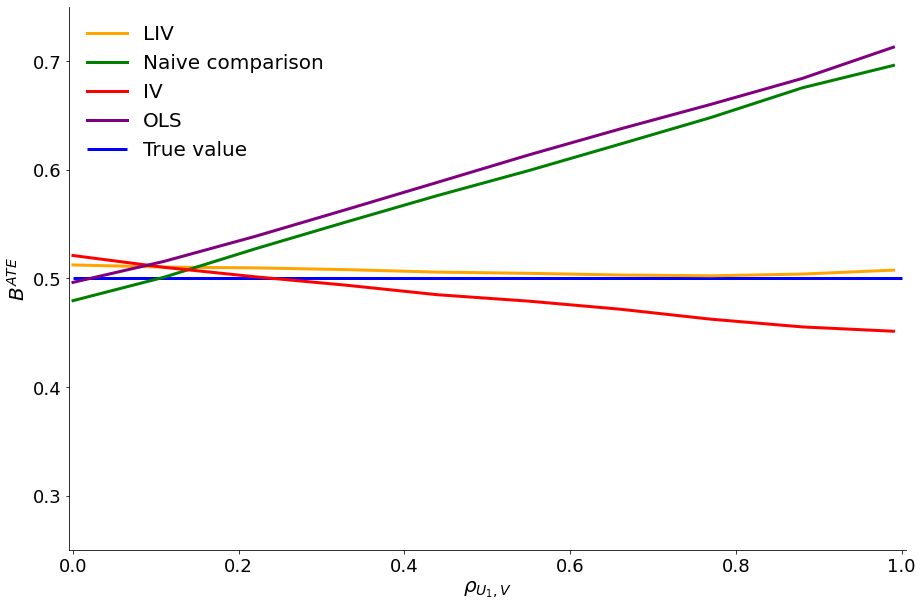

In [140]:
grid = np.linspace(0.00, 0.99, 10)

# Plot all graphs in one plot
ax2 = plt.figure(figsize=(15, 10)).add_subplot(111)
ax2.set_xlim([-0.005, 1.005])
ax2.set_ylim(0.25, 0.75)
ax2.set_ylabel(r"$B^{ATE}$", fontsize=20)
ax2.set_xlabel(r"$\rho_{U_1, V}$", fontsize=20)
plt.rc("xtick", labelsize=18)
plt.rc("ytick", labelsize=18)

# Plot evaluated effects
ax2.hlines(0.5, 0.0, 1.0, color="blue", label="True value", linewidth=3.0)
ax2.plot(grid, effects["grmpy"], label="LIV", color="orange", linewidth=3.0)
ax2.plot(
    grid, effects["random"], label="Naive comparison", color="green", linewidth=3.0
)
ax2.plot(grid, effects["iv"], label="IV", color="red", linewidth=3.0)
ax2.plot(
    grid, effects["ols"], label="OLS", color="purple", linewidth=3.0,
)

plt.legend(prop={"size": 20})